In [1]:
import utils
import Simple_CNN

import matplotlib.pyplot as plt

import torch
import torchsummary
from torchvision import transforms

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

from torch.utils.data import DataLoader

from sklearn.preprocessing import OneHotEncoder


import numpy as np
from importlib import reload

import yaml

In [2]:
with open("SimpleCNN.yaml", "r") as f:
  net_archi = yaml.load(f, Loader=yaml.FullLoader)
  
  print(net_archi)

{'SimpleCNN2out_noDrop': {'input_shape': [3, 1024, 256], 'conv_channels': [8, 16, 32, 16, 8, 4], 'conv_kernel_size': [2, 2, 2, 2, 2, 2], 'pooling_size': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'conv_dropout': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'linear_features': [32, 2], 'linear_dropout': [0.0], 'last_layer_activation': 'Softmax(dim=1)'}, 'SimpleCNN2out_Drop': {'input_shape': [3, 1024, 256], 'conv_channels': [8, 16, 32, 16, 8, 4], 'conv_kernel_size': [2, 2, 2, 2, 2, 2], 'pooling_size': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'conv_dropout': [0.0, 0.0, 0.2, 0.2, 0.0, 0.0], 'linear_features': [64, 2], 'linear_dropout': [0.4], 'last_layer_activation': 'Softmax(dim=1)'}, 'SimpleCNN2out_Drop_2': {'input_shape': [3, 1024, 256], 'conv_channels': [8, 16, 32, 16, 8, 4], 'conv_kernel_size': [2, 2, 2, 2, 2, 2], 'pooling_size': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'conv_dropout': [0.2, 0.2, 0.2, 0.2, 0.2, 0.2], 'linear_features': [6, 2], 'linear_dropout': [0.4], 'last

In [3]:
# Parameters
random_seed = 42

batch_size = 16
lr = 0.001
epochs = 100

net_name = "SimpleCNN2out_Drop_2"

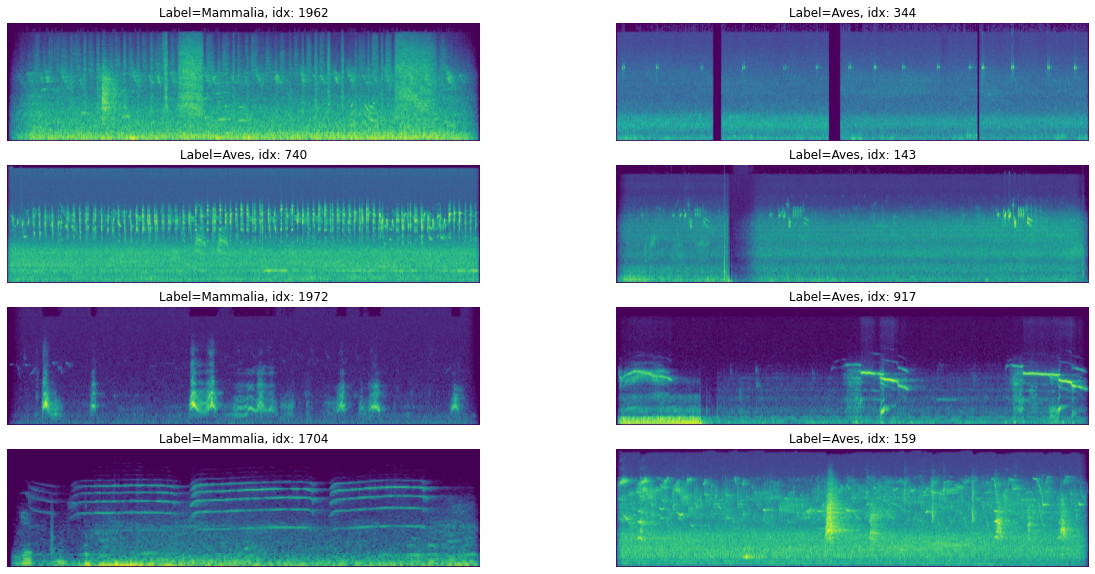

In [4]:
reload(utils)

transform_img = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

transform_labels = transforms.Compose(
    [transforms.ToTensor()]
)

dataset = utils.SpectrogramDataset("../datasets/Aves-Mammalia.csv", 
                                   "../spectrograms/small_dataset", 
                                   "gbifID", "class", 
                                   transform=transform_img, 
                                   one_hot_encode_labels=True)
dataset.show_sample(8, figsize=(20, 10))

In [8]:
dataset.csv

,gbifID,class,file_name
0,1052813851,Aves,Chordata/Aves/Turdidae/Turdus/Turdus_philomelo...
1,1229950816,Aves,Chordata/Aves/Accipitridae/Aquila/Aquila_rapax...
2,779855502,Aves,Chordata/Aves/Fringillidae/Fringilla/Fringilla...
3,1229950910,Aves,Chordata/Aves/Accipitridae/Buteo/Buteo_rufinus...
4,779853615,Aves,Chordata/Aves/Emberizidae/Emberiza/Emberiza_ho...
...,...,...,...
1995,779847924,Mammalia,Chordata/Mammalia/Callitrichidae/Callithrix/Ca...
1996,779854254,Mammalia,Chordata/Mammalia/Equidae/Equus/Equus_caballus...
1997,779847968,Mammalia,Chordata/Mammalia/Camelidae/Camelus/Camelus_ba...
1998,779852429,Mammalia,Chordata/Mammalia/Sciuridae/Cynomys/Cynomys_lu...


In [5]:
test_percentage = .2
test_len = int((len(dataset) * test_percentage))
train_len = len(dataset) - test_len

train, test = random_split(dataset, [train_len, test_len], torch.Generator().manual_seed(random_seed))

train_loader = DataLoader(train, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

In [6]:
len(train_loader.dataset), len(test_loader.dataset)

(1600, 400)

In [7]:
net_archi[net_name]

{'input_shape': [3, 1024, 256],
 'conv_channels': [8, 16, 32, 16, 8, 4],
 'conv_kernel_size': [2, 2, 2, 2, 2, 2],
 'pooling_size': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]],
 'conv_dropout': [0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
 'linear_features': [64, 2],
 'linear_dropout': [0.4],
 'last_layer_activation': 'Softmax(dim=0)'}

In [8]:
reload(Simple_CNN)
net = Simple_CNN.SimpleCNN(net_archi[net_name])

net = utils.cuda_network(net)

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = lr)

# torchsummary.summary(net, (3, 1024, 256))

/home/pheithar/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:
net.parameters

<bound method Module.parameters of SimpleCNN(
  (conv): ModuleList(
    (0): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (1): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (3): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (4): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (5): Conv2d(8, 4, kernel_size=(2, 2), stride=(1, 1), padding=same)
  )
  (bnorm): ModuleList(
    (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): BatchNorm2d(4, eps=1e

In [10]:
torchsummary.summary(net, (3, 1024, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 8, 1024, 256]             104
       BatchNorm2d-2         [-1, 8, 1024, 256]              16
         MaxPool2d-3          [-1, 8, 512, 128]               0
              ReLU-4          [-1, 8, 512, 128]               0
           Dropout-5          [-1, 8, 512, 128]               0
            Conv2d-6         [-1, 16, 512, 128]             528
       BatchNorm2d-7         [-1, 16, 512, 128]              32
         MaxPool2d-8          [-1, 16, 256, 64]               0
              ReLU-9          [-1, 16, 256, 64]               0
          Dropout-10          [-1, 16, 256, 64]               0
           Conv2d-11          [-1, 32, 256, 64]           2,080
      BatchNorm2d-12          [-1, 32, 256, 64]              64
        MaxPool2d-13          [-1, 32, 128, 32]               0
             ReLU-14          [-1, 32, 

/home/pheithar/.local/lib/python3.9/site-packages/torch/nn/modules/conv.py:439: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /pytorch/aten/src/ATen/native/Convolution.cpp:660.)
  return F.conv2d(input, weight, bias, self.stride,
/home/pheithar/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
torch.cuda.empty_cache()
((train_loss, train_acc),
 (val_loss, val_acc)) = net.fit(epochs, train_loader, test_loader, criterion, optimizer,
                             log_file=net_name+".log", 
                             plot_file=net_name+".png", 
                             train_name=net_name)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

In [ ]:
print("Train set:")
print(f"\tLoss: \t\t{train_loss:.2f}")
print(f"\tAccuracy: \t{train_acc:.2f}")

print("Validation set:")
print(f"\tLoss: \t\t{val_loss:.2f}")
print(f"\tAccuracy: \t{val_acc:.2f}")